In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from numpy import linalg as LA
from collections import defaultdict
import numpy as np
import random
from community import community_louvain
from graphrole import RecursiveFeatureExtractor, RoleExtractor
import multiprocessing as mp
import itertools
from numpy import linalg as LA
from os import cpu_count
import time

In [2]:
world = pd.read_csv("World.csv")
world = world.drop(['ConexionAeropuertos'], axis=1)
world

,Origen,Destino
0,Papua New Guinea,Australia
1,Papua New Guinea,Philippines
2,Papua New Guinea,Indonesia
3,Papua New Guinea,Solomon Islands
4,Papua New Guinea,Hong Kong
...,...,...
2847,Lithuania,Georgia
2848,Armenia,Georgia
2849,Eritrea,Yemen
2850,Yemen,Djibouti


Ejercicio 1.

a. Obtener una visualización de las comunidades presentes en dicha red (indicando el algoritmo utilizado).

b. Considerando lo que respondiste en el parcialito 1 (ejercicio 2):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i. Si mencionaste que había homofilia, ¿corresponde por el mismo tipo que mencionaste anteriormente? &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;¿por
qué?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii. Si mencionaste que no había homofilia (o bien no realizaste el ejercicio), ¿qué tipo de homofilia se puede &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ver
presente?

c. Obtener los nodos correspondientes a una de las subredes (con al menos 20% de los nodos), y realizar una
visualización de las sub-comunidades presentes.

In [3]:
## Genero el grafo que va a representar la red. ##
grafo = nx.from_pandas_edgelist(world, 'Origen', 'Destino')

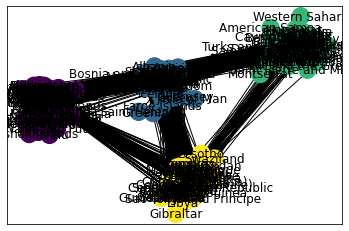

In [4]:
# Ejercicio 1.a

'''
algoritmo basado al encontrado en: 
https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx
'''

def community_layout(g, partition):
    pos_communities = _position_communities(g, partition, scale=3.)
    pos_nodes = _position_nodes(g, partition, scale=1.)

    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):
    edges = dict()
    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)
   
    return pos

def graficar_comunidades(g):
    partition = community_louvain.best_partition(g)
    pos = community_layout(g, partition)
    nx.draw_networkx(g, pos, node_color=list(partition.values()), with_labels=True); 
    plt.rcParams["figure.figsize"] = (20,8)
    plt.show()
    return

graficar_comunidades(grafo)

Ejercicio 1 b. 

El resultado coincide con lo obtenido en el primer parcialito. Las comunidades en este grafo pertenecen a continentes o "lugares geograficos". Por ejemplo america y caribe se lo podria ver como una comunidad.

Esto tiene mucho sentido ya que los vuelos suelen ser mas frecuentes entre paises limitrofes o de zonas cercanas.

El algoritmo utilizado es Louvain.

In [5]:
# Ejercicio 1.c
comunidades = community_louvain.best_partition(grafo)
grupo_asia_oceania = dict()

for key, value in comunidades.items():
    if value == 0:
        grupo_asia_oceania[key] = value

grafo_asia_oceania = grafo

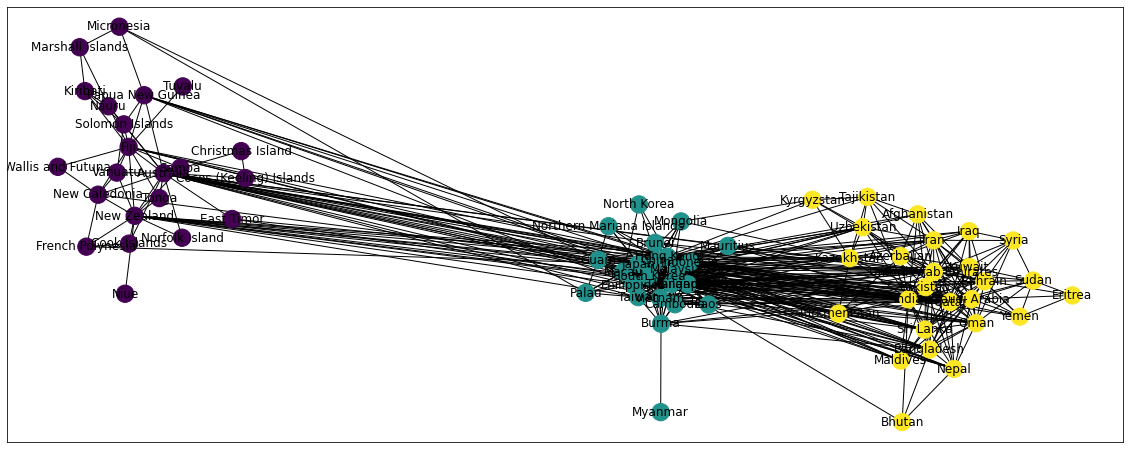

In [6]:
for node in list(grafo_asia_oceania.nodes):
    if grupo_asia_oceania.get(node) == None:
        grafo_asia_oceania.remove_node(node)

graficar_comunidades(grafo_asia_oceania)

Los subgrupos en esta red tambien estan muy marcados. Este subgrupo se lo podria denominar como un grupo compuesto por paises de Asia y Oceania. Donde los subgrupos serian los lugares o zonas geograficas. Por ejemplo todos los paises oceanicos estan en un grupo, los asiaticos-orientales por otro y finalmente el ultimo los asiaticos arabes y ex union sovietica.

Ejercicio 2

a. Calcular los motifs de hasta 5 nodos de la subred definida en el punto 1.c.

b. Calcular el promedio y desvío estandar de los motifs de una red de baseline. Calcular el significant profile de la
red, y hacer un gráfico.

c. Intentar dar con una explicación del resultado obtenido en el punto anterior [+1 punto].

Ejercicio 3

Detectar los roles en dicha red utilizando el algoritmo RolX, explicando el resultado obtenido.

In [7]:
'''
algoritmo basado al encontrado en:
https://drive.google.com/file/d/11heexfkwbJdl8TPJHnbEic4RdVzFMeR6/view?usp=sharing
'''

def extract_roles_and_plot(G, title='',save = False ,file_name='', big=False):
    feature_extractor = RecursiveFeatureExtractor(G)
    features = feature_extractor.extract_features()
    role_extractor = RoleExtractor(n_roles=None)
    role_extractor.extract_role_factors(features)
    labels = {node: node for node in G.nodes()}

    available_colors = \
    {'role_0':'#E9D758', 'role_1':'#297373', 'role_2':'#ff8552','role_3':'#888888', 'role_4':'#00aa00','role_5':'#aaaa00','role_6':'#aa0000' , 'role_7':'#0000aa'}
    
    colors = [available_colors[role_extractor.roles[node]] for node in G.nodes()]
    
    pos = nx.kamada_kawai_layout(G)
    if big:
        plt.figure(figsize=(25,25))
    else:
        plt.figure(figsize=(20,20))
    plt.title(title)

    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=colors, alpha=0.7,node_size=200, linewidths=2)
    nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.05)
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    if save:
        plt.savefig(file_name, format = 'svg', dpi=300)
        plt.figure(figsize=(10,10))
    plt.title(title)

    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=colors, alpha=0.7,node_size=200, linewidths=2)
    nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    if save:
        plt.savefig(file_name, format = 'svg', dpi=300)

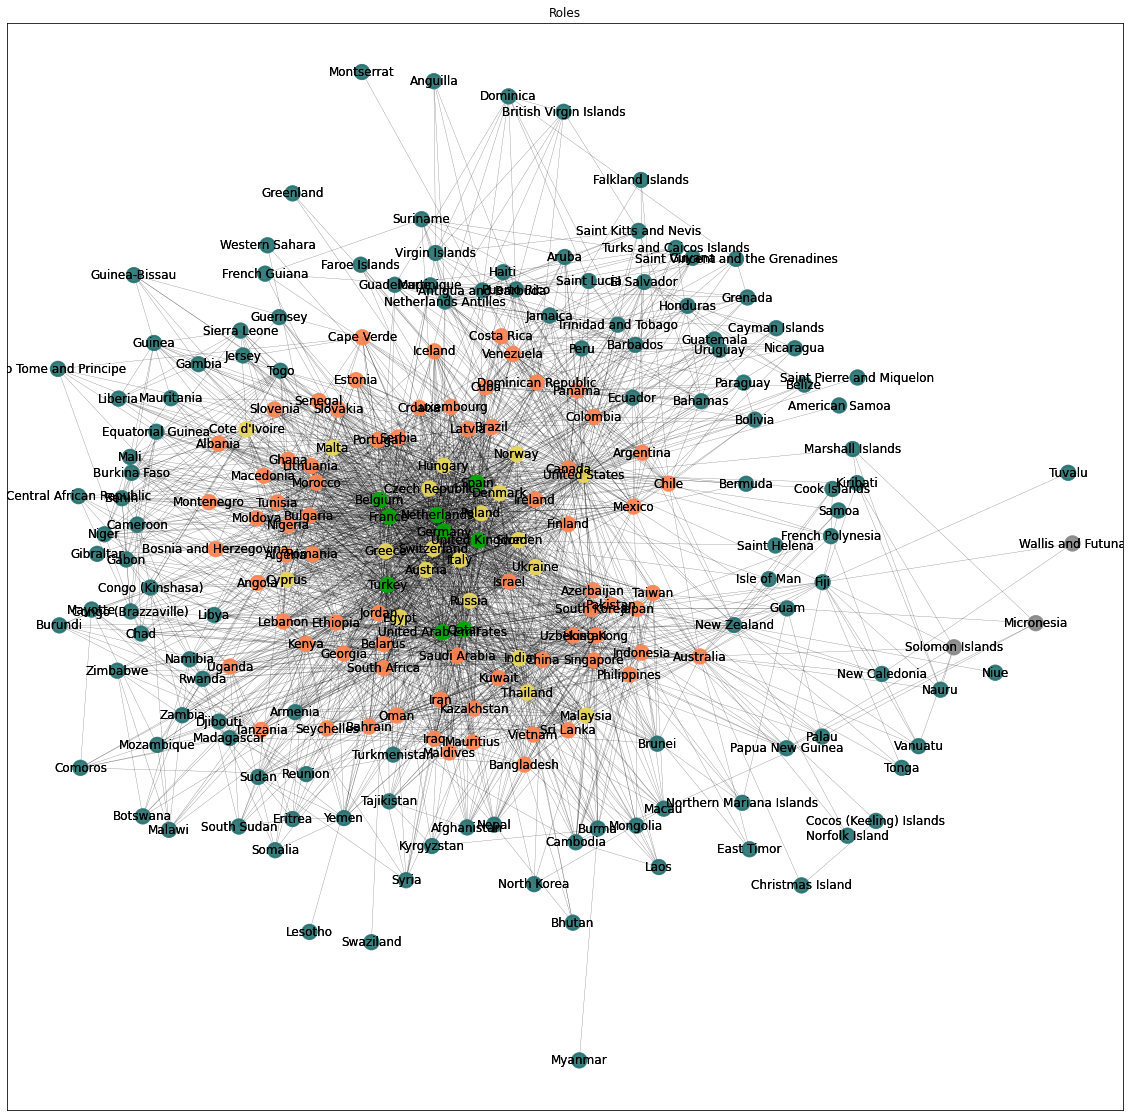

In [8]:
grafo = nx.from_pandas_edgelist(world, 'Origen', 'Destino')

extract_roles_and_plot(grafo,title='Roles', save=False, file_name='img/roles_ep4.svg')

Como el grafico no es del todo entendible (hay una gran cantidad de nodos, quizas graficando un subgrupo se hace mas entendible el grafico) voy a ver que paises pertenecen a cada rol para hacer el analisis. 

In [9]:
feature_extractor = RecursiveFeatureExtractor(grafo)
features = feature_extractor.extract_features()
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)

In [10]:
paises_por_roles = [[], [], [], [], [], [], [], []]
    
for i in range(0,5):
    for key, value in role_extractor.roles.items():
        if i == int(value[len(value)-1]):
            paises_por_roles[i].append(key)  
            
for i in range(0,5):
    print('Los paises pertenecientes al rol', i, 'son:')
    for value in paises_por_roles[i]:
        print(value, end=', ')
    print('\n')

Los paises pertenecientes al rol 0 son:
Austria, Cote d'Ivoire, Cyprus, Czech Republic, Denmark, Egypt, Greece, Hungary, India, Italy, Malaysia, Malta, Norway, Poland, Russia, Sweden, Switzerland, Thailand, Ukraine, United States, 

Los paises pertenecientes al rol 1 son:
Afghanistan, American Samoa, Anguilla, Antigua and Barbuda, Armenia, Aruba, Bahamas, Barbados, Belize, Benin, Bermuda, Bhutan, Bolivia, Botswana, British Virgin Islands, Brunei, Burkina Faso, Burma, Burundi, Cambodia, Cameroon, Cayman Islands, Central African Republic, Chad, Christmas Island, Cocos (Keeling) Islands, Comoros, Congo (Brazzaville), Congo (Kinshasa), Cook Islands, Djibouti, Dominica, East Timor, Ecuador, El Salvador, Equatorial Guinea, Eritrea, Falkland Islands, Faroe Islands, Fiji, French Guiana, French Polynesia, Gabon, Gambia, Gibraltar, Greenland, Grenada, Guadeloupe, Guam, Guatemala, Guernsey, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Isle of Man, Jamaica, Jersey, Kiribati, Kyrgyzstan, Laos, L

Combinando la informacion recien impresa y el grafico podemos determinar que los paises pertenecientes a los roles 1 y 3 son los nodos perifericos. Lo cual tiene sentido ya que son los paises con menor conexion de vuelos.
Por otra parte, los nodos del rol 4 (color verde claro) son los nodos centrales. Estos paises son de los mas desarrollados, con mejor ubicacion y lugares estrategicos claves para la conexion de muchos vuelos a todos los paises del mundo.